In [388]:
library(data.table)
library(foreign)
library(sandwich)
library(lmtest)
library(stargazer)
library(lfe)
library(car)
library(ggplot2)
options(digits=5)
library(data.table)
library(knitr)
library(rgeolocate)
library(data.table)
library(knitr)
library(lmtest)
library(ri2)
library(dplyr)

## Null & Alternate Hypothesis 

- _NULL Hypothesis_ : **Make people aware of the prevalence of fake news has no effect on its believabiliy**
- _Alternate Hypothesis_ : **General flags about fake news reduce its believability**


## Calculating the sample size

In this section, we calculate the minimum required sample size for our experiment. 

The statistical power of an experiment is the experiment's abilitiy to reject the NULL hypothesis when a specific alternate hypothesis is true.

$$ \alpha = P(\text{reject}\ H_0 | H_0) $$

where $ \alpha $ is the significance level. We select a significance level of $\alpha = 0.05$ as a tolerance for Type I errors in our experiment. 

Now that we have chosen our significance level, we would like to minimize the probability of Type II error. i.e. we would like to **maximize** the power of our test against the relevan alternative. Mathematically, power is 

$$ power = 1 - P_r(\text{Type II Error}) = P_r(\text{reject}\ H_0 | H_1 \text{is true}) $$

- We would set the required power of our experiment to be **80%** for this study as a reasonable expectation.
- To calculate the power for the test, we need to conjecture an expected ATE and the standard deviation for the outcome in the experiment. 
- The outcome is a rating on a scale of 0-10 on how successfull the red flag was in reducing the believability of the fake/misleading social media post. We would like our experiment to be able detect a difference in means of minimum 2 points on this scale. 
- We do expect the measured values for this rating to vary significantly as we poll subjects with different political opinions, life experiences and political affiliations. To be on the conservative side, we would like to have enough power in our experiment to minimize Type II errors when the std. deviation is at least 2.5 times the minimum detectable treatment effect. 

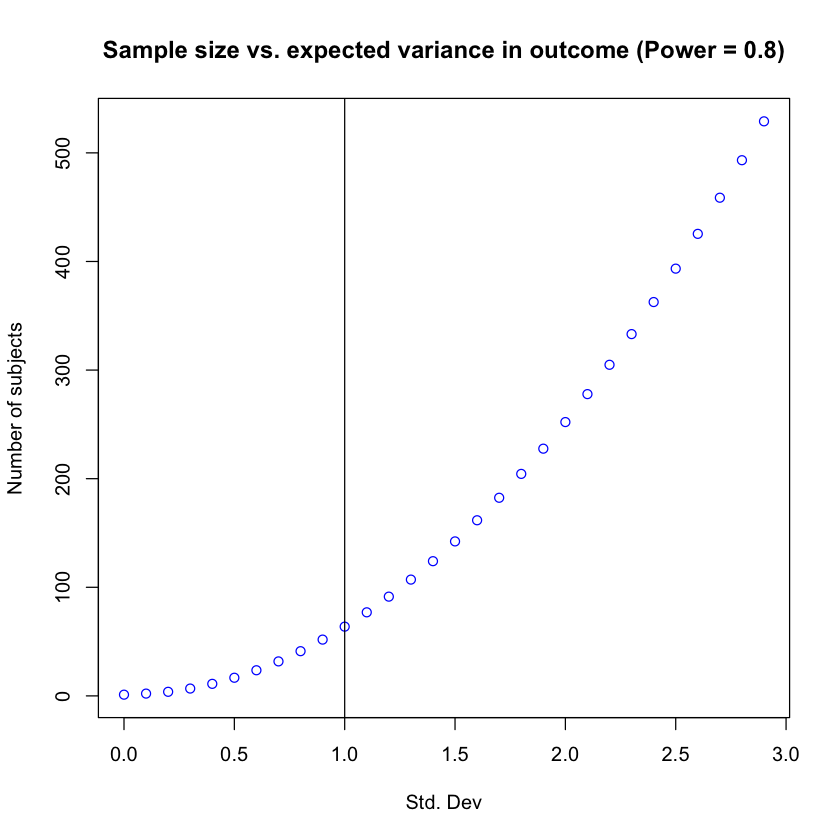

In [389]:
power_sim <- function(ate,sig_level=0.05,power=0.8,alternate_hyp="two.sided", sd = 1){
    result <- NA
    sims <- seq(1e-5,sd,by=0.1)
    for(i in seq_along(sims)){
        result[i] <- power.t.test(d=ate, 
                               sig.level=sig_level, 
                               power=power,
                               sd=sims[i],
                               alternative=alternate_hyp)$n
        }
    return(result)
    }
sd <- 3
expected_ate <- 0.5
x <- seq(1e-5,sd, by = 0.1)
samples <- power_sim(ate=expected_ate,sd = sd)
plot(x = x, y=samples,col = 'blue',
     xlab="Std. Dev",
     ylab = 'Number of subjects',
     main = "Sample size vs. expected variance in outcome (Power = 0.8)")
abline(v=1.0,col='black',lwd=1)

The above plot shows that we need a minimum sample size of 100 to achieve a power of 0.8 when the outcome variable has a standard deviation 1.0 times the treatment effect. 

The plot below, validates that the absolute value of minimum treatment effect doesn't change the sample size requirement significantly and that this is determined mostly by the expected variance in the measurement data.

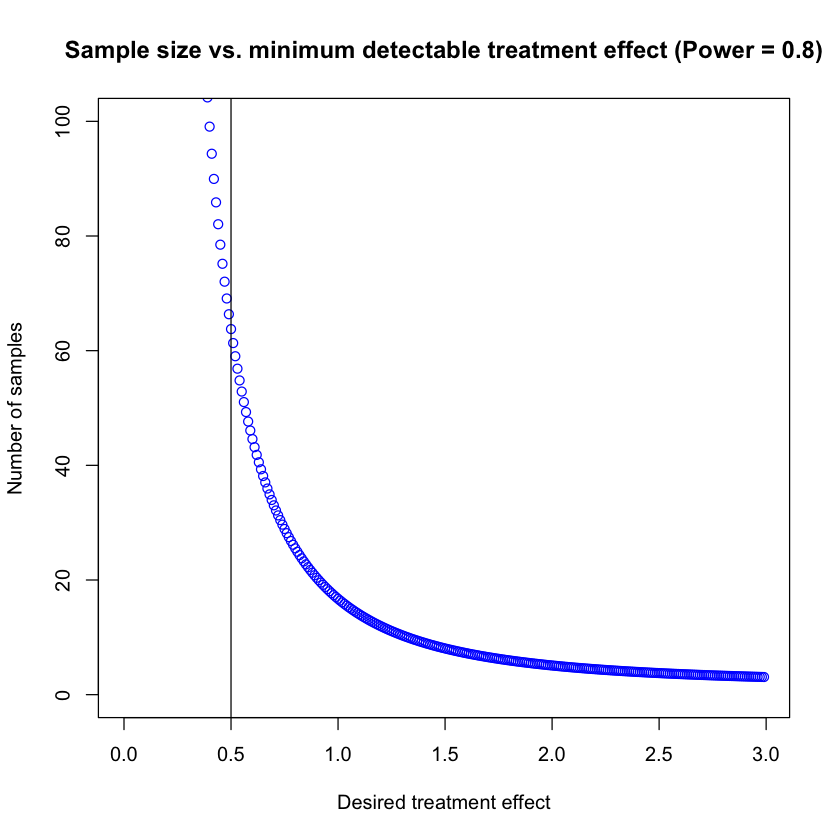

In [390]:
power_sim_by_ate <- function(ate_vector,sig_level=0.05,power=0.8,alternate_hyp="two.sided",sd = 1){
    result <- NA
    for(i in seq_along(ate_vector)){
        result[i] <- power.t.test(d=ate_vector[i], 
                               sig.level=sig_level, 
                               power=power,
                               sd=sd,
                               alternative=alternate_hyp)$n
        }
    return(result)
    }
sd <- 1
expected_ate <- 3
x <- seq(1e-5,expected_ate,by=0.01)
samples <- power_sim_by_ate(ate=x,sd = sd)

plot(x = x, y=samples,col = 'blue',
     xlab= "Desired treatment effect",
     ylab = 'Number of samples',ylim=c(0,100),
     main = "Sample size vs. minimum detectable treatment effect (Power = 0.8)")
abline(v=0.5,col='black',lwd=1)

### Pilot study 

- To validate our assumptions number of subjects and respondent/compliance rate (30 subjects in pilot)
- Create a short survey with questions and tweets (Imran)
- Mine controversial tweets (Kevin)
- How to administer the survey (Suhas)

## Covariates to ask in survey

- Gender
- Age 
- Political affiliation 
- Registered Voter / non-voter 
- race
- are you active on social media?  
- education (< high school, high school , undergrad, grad)

## Covariates in regression in addition to above (not in survey) 

- Mturk subject?
- location of subject


## Experimental Design 

### 2 x 2

- treatment : 
     - banner or no banner 
     - tweet is false or true

- block by party affiliation and gender 

### Treatment  & control assginment 
 - how to randomly assign while blocking for above


## Regression Models


### Outcome: Belief in authenticity of a fake post

1. Baseline model 

 outcome ~ general_flag on survey page
 
2. Model with co-variates 

outcome ~ red_flag * gender + red_flag * political_affiliation  + factor(age_group) + factor(education) + red_flag * location + registered_voter + race + social_media_active + 

3. Model with treatment-covariate interactions  

    - Test if fake news red flagging affects democrats and republicans differently 
    - Test if fake news red flagging affects different age groups differently 
    - Test if fake news red flagging affects voters and non voters differently 



## Instructor Feedback on Essay 2

- Are we telling people that a "flag" means "fake"? If so, it seems like the treatment effect will obvisouly be positive. 
    - Make the flag explicit "fake/false"
    - Can we have levels of treatment ? 
    
- MTurk people differ from typical individuals in several important ways 
    - Add covariate indicating whether subject is Mtruk recruit
- I think i’ve read somewhere that men and women tend to believe in different kinds of nonsense. E.g. men are more likely to believe that “climate change is a hoax” but women are more likely to believe in e.g. BS diets.
    - Should we block on gender ? How is blocking implemented in experiment (factor in the regression when doing the analysis ? )
    - Have an interaction term of treatment (flag) with gender 
    - Have equal number of subject of both gender in treatment and control 

Hows grouping done : 
 - Each subject sees some tweets that are no banner, and some with banner ? 
 - Or, each subject is only sees all control tweets or all treatment tweets ?
 
 - Randomly assign labels (no banner, true banner, false banner) to a tweet for creating a survey for each individual

### Pilot data analysis

In [605]:
full_dataset <- fread('./data/pilot/pilot_data_07262020.csv')

In [606]:
head(full_dataset)
names(full_dataset)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,⋯,8A,9A,10A,11A,12A,13A,14A,15A,16A,17A
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,⋯,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?,Do you believe that the content of the above post is true?
"{""""ImportId"""":""""startDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""endDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""status""""}","{""""ImportId"""":""""ipAddress""""}","{""""ImportId"""":""""progress""""}","{""""ImportId"""":""""duration""""}","{""""ImportId"""":""""finished""""}","{""""ImportId"""":""""recordedDate"""",""""timeZone"""":""""America/Denver""""}","{""""ImportId"""":""""_recordId""""}","{""""ImportId"""":""""recipientLastName""""}",⋯,"{""""ImportId"""":""""QID32""""}","{""""ImportId"""":""""QID33""""}","{""""ImportId"""":""""QID34""""}","{""""ImportId"""":""""QID35""""}","{""""ImportId"""":""""QID36""""}","{""""ImportId"""":""""QID37""""}","{""""ImportId"""":""""QID38""""}","{""""ImportId"""":""""QID39""""}","{""""ImportId"""":""""QID40""""}","{""""ImportId"""":""""QID41""""}"
2020-07-17 18:52:45,2020-07-17 18:59:24,IP Address,73.93.90.157,100,399,True,2020-07-17 18:59:25,R_u8Geu0CykTxNh6h,,⋯,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,No
2020-07-17 19:46:06,2020-07-17 19:48:33,IP Address,98.234.117.52,100,147,True,2020-07-17 19:48:34,R_2EgXOU7K2nTlgqG,,⋯,,,,,,,,,,
2020-07-17 19:48:21,2020-07-17 19:59:28,IP Address,71.244.172.196,100,666,True,2020-07-17 19:59:28,R_1NgJqwlFgUpLjT1,,⋯,Yes,Yes,No,Yes,No,No,No,Yes,No,No
2020-07-17 20:01:07,2020-07-17 20:04:12,IP Address,173.67.9.152,100,185,True,2020-07-17 20:04:13,R_33woiiDhvnhBZZR,,⋯,,,,,,,,,,


[1] "StartDate"             "EndDate"               "Status"               
 [4] "IPAddress"             "Progress"              "Duration (in seconds)"
 [7] "Finished"              "RecordedDate"          "ResponseId"           
[10] "RecipientLastName"     "RecipientFirstName"    "RecipientEmail"       
[13] "ExternalReference"     "LocationLatitude"      "LocationLongitude"    
[16] "DistributionChannel"   "UserLanguage"          "Q_RecaptchaScore"     
[19] "Q1"                    "Q2"                    "Q3"                   
[22] "Q4"                    "Q5"                    "Q6"                   
[25] "Q7"                    "8B"                    "9B"                   
[28] "10B"                   "11B"                   "12B"                  
[31] "13B"                   "14B"                   "15B"                  
[34] "16B"                   "17B"                   "8A"                   
[37] "9A"                    "10A"                   "11A"                  
[40] "12A"                   "13A"                   "14A"                  
[43] "15A"                   "16A"                   "17A"

In [607]:
data_pruned <- full_dataset[ 3:nrow(full_dataset),]
data_pruned[, c(6,7)] <- lapply(data_pruned[, c(6,7)], as.numeric)

Warning message in lapply(data_pruned[, c(6, 7)], as.numeric):
“NAs introduced by coercion”


In [608]:

question_col_names <- c('8B','9B','10B','11B','12B','13B','14B','15B','16B','17B',
                        '8A','9A','10A','11A','12A','13A','14A','15A','16A','17A')
for(i in c(26:length(names(data_pruned)))){
    data_pruned[[i]][data_pruned[[i]]==''] <- NA
}

# Check the data
head(data_pruned[, 26:length(names(data_pruned))])

# Set assignment group variable (treatment = 1 , conrol = 0)
data_pruned[, assignment := ifelse(is.na(data_pruned[,'8B']),0,1)]
head(data_pruned[, 26:length(names(data_pruned))])


8B,9B,10B,11B,12B,13B,14B,15B,16B,17B,8A,9A,10A,11A,12A,13A,14A,15A,16A,17A
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,No
Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Yes,Yes,No,Yes,No,No,No,Yes,No,No
No,Yes,No,Yes,No,No,Yes,Yes,No,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Yes,Yes,No,Yes,No,No,Yes,Yes,No,No
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,No,Yes,No,Yes,No,No,No,No,No,No


Warning message in `[.data.table`(data_pruned, , `:=`(assignment, ifelse(is.na(data_pruned[, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


8B,9B,10B,11B,12B,13B,14B,15B,16B,17B,⋯,9A,10A,11A,12A,13A,14A,15A,16A,17A,assignment
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,Yes,No,Yes,Yes,No,Yes,Yes,No,No,0
Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,Yes,No,Yes,No,No,No,Yes,No,No,0
No,Yes,No,Yes,No,No,Yes,Yes,No,No,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,Yes,No,Yes,No,No,Yes,Yes,No,No,0
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,Yes,No,Yes,No,No,No,No,No,No,0


In [609]:
head(data_pruned)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,⋯,9A,10A,11A,12A,13A,14A,15A,16A,17A,assignment
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2020-07-17 18:52:45,2020-07-17 18:59:24,IP Address,73.93.90.157,100,399,NA,2020-07-17 18:59:25,R_u8Geu0CykTxNh6h,,⋯,Yes,No,Yes,Yes,No,Yes,Yes,No,No,0
2020-07-17 19:46:06,2020-07-17 19:48:33,IP Address,98.234.117.52,100,147,NA,2020-07-17 19:48:34,R_2EgXOU7K2nTlgqG,,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
2020-07-17 19:48:21,2020-07-17 19:59:28,IP Address,71.244.172.196,100,666,NA,2020-07-17 19:59:28,R_1NgJqwlFgUpLjT1,,⋯,Yes,No,Yes,No,No,No,Yes,No,No,0
2020-07-17 20:01:07,2020-07-17 20:04:12,IP Address,173.67.9.152,100,185,NA,2020-07-17 20:04:13,R_33woiiDhvnhBZZR,,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
2020-07-17 19:58:48,2020-07-17 20:13:25,IP Address,174.195.207.41,100,876,NA,2020-07-17 20:13:25,R_3nAiDFypCLOOxYV,,⋯,Yes,No,Yes,No,No,Yes,Yes,No,No,0
2020-07-17 20:08:21,2020-07-17 20:17:59,IP Address,67.188.128.89,100,578,NA,2020-07-17 20:18:00,R_3QXbtPAqPrxpNRD,,⋯,Yes,No,Yes,No,No,No,No,No,No,0


In [611]:
answer_guide <- c('Yes','Yes','No','Yes','No','No','Yes','Yes','No','No',
                  'Yes','Yes','No','Yes','No','No','Yes','Yes','No','No')

compute_scores <- function(dataset,answer_guide){
    for(i in 1:nrow(data_pruned)){
    dataset[i,"score"] <- sum(dataset[i,26:45] == answer_guide,na.rm=TRUE)
    }
    return(dataset)
}


data_w_scores <- compute_scores(data_pruned,answer_guide)
head(data_w_scores)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,⋯,10A,11A,12A,13A,14A,15A,16A,17A,assignment,score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
2020-07-17 18:52:45,2020-07-17 18:59:24,IP Address,73.93.90.157,100,399,NA,2020-07-17 18:59:25,R_u8Geu0CykTxNh6h,,⋯,No,Yes,Yes,No,Yes,Yes,No,No,0,9
2020-07-17 19:46:06,2020-07-17 19:48:33,IP Address,98.234.117.52,100,147,NA,2020-07-17 19:48:34,R_2EgXOU7K2nTlgqG,,⋯,NA,NA,NA,NA,NA,NA,NA,NA,1,8
2020-07-17 19:48:21,2020-07-17 19:59:28,IP Address,71.244.172.196,100,666,NA,2020-07-17 19:59:28,R_1NgJqwlFgUpLjT1,,⋯,No,Yes,No,No,No,Yes,No,No,0,9
2020-07-17 20:01:07,2020-07-17 20:04:12,IP Address,173.67.9.152,100,185,NA,2020-07-17 20:04:13,R_33woiiDhvnhBZZR,,⋯,NA,NA,NA,NA,NA,NA,NA,NA,1,9
2020-07-17 19:58:48,2020-07-17 20:13:25,IP Address,174.195.207.41,100,876,NA,2020-07-17 20:13:25,R_3nAiDFypCLOOxYV,,⋯,No,Yes,No,No,Yes,Yes,No,No,0,10
2020-07-17 20:08:21,2020-07-17 20:17:59,IP Address,67.188.128.89,100,578,NA,2020-07-17 20:18:00,R_3QXbtPAqPrxpNRD,,⋯,No,Yes,No,No,No,No,No,No,0,7


In [644]:
sd_pilot <- data_w_scores[, sd(score)]
sd
d <- data_w_scores[, .(scores=mean(score)), by = assignment]
mod <- lm(score ~ assignment, data_w_scores)
stargazer(mod, type="text")
ate <- diff(d$scores)
ate

[1] 1.3434


                        Dependent variable:    
                    ---------------------------
                               score           
-----------------------------------------------
assignment                    -0.274           
                              (0.536)          
                                               
Constant                     7.857***          
                              (0.364)          
                                               
-----------------------------------------------
Observations                    26             
R2                             0.011           
Adjusted R2                   -0.030           
Residual Std. Error       1.364 (df = 24)      
F Statistic             0.261 (df = 1; 24)     
Note:               *p<0.1; **p<0.05; ***p<0.01


[1] -0.27381

In [659]:
## Power calculation 
power.t.test(d=ate,sig.level=0.95,power=0.9,sd=sd,alternative="two.sided")


     Two-sample t test power calculation 

              n = 86.994
          delta = 0.27381
             sd = 1.3434
      sig.level = 0.95
          power = 0.9
    alternative = two.sided

NOTE: n is number in *each* group


In [660]:
data_mod <- rename(data_w_scores, 
       Gender = Q1,
       Reg_Voter = Q2,
       Age_bin = Q3,
       Party = Q4,
       Education = Q5,
       Ethnicity = Q6,
       Soc_Med_Active = Q7
        )

names(data_mod)

[1] "StartDate"             "EndDate"               "Status"               
 [4] "IPAddress"             "Progress"              "Duration (in seconds)"
 [7] "Finished"              "RecordedDate"          "ResponseId"           
[10] "RecipientLastName"     "RecipientFirstName"    "RecipientEmail"       
[13] "ExternalReference"     "LocationLatitude"      "LocationLongitude"    
[16] "DistributionChannel"   "UserLanguage"          "Q_RecaptchaScore"     
[19] "Gender"                "Reg_Voter"             "Age_bin"              
[22] "Party"                 "Education"             "Ethnicity"            
[25] "Soc_Med_Active"        "8B"                    "9B"                   
[28] "10B"                   "11B"                   "12B"                  
[31] "13B"                   "14B"                   "15B"                  
[34] "16B"                   "17B"                   "8A"                   
[37] "9A"                    "10A"                   "11A"                  
[40] "12A"                   "13A"                   "14A"                  
[43] "15A"                   "16A"                   "17A"                  
[46] "assignment"            "score"

In [661]:
head(data_mod)

StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,⋯,10A,11A,12A,13A,14A,15A,16A,17A,assignment,score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
2020-07-17 18:52:45,2020-07-17 18:59:24,IP Address,73.93.90.157,100,399,NA,2020-07-17 18:59:25,R_u8Geu0CykTxNh6h,,⋯,No,Yes,Yes,No,Yes,Yes,No,No,0,9
2020-07-17 19:46:06,2020-07-17 19:48:33,IP Address,98.234.117.52,100,147,NA,2020-07-17 19:48:34,R_2EgXOU7K2nTlgqG,,⋯,NA,NA,NA,NA,NA,NA,NA,NA,1,8
2020-07-17 19:48:21,2020-07-17 19:59:28,IP Address,71.244.172.196,100,666,NA,2020-07-17 19:59:28,R_1NgJqwlFgUpLjT1,,⋯,No,Yes,No,No,No,Yes,No,No,0,9
2020-07-17 20:01:07,2020-07-17 20:04:12,IP Address,173.67.9.152,100,185,NA,2020-07-17 20:04:13,R_33woiiDhvnhBZZR,,⋯,NA,NA,NA,NA,NA,NA,NA,NA,1,9
2020-07-17 19:58:48,2020-07-17 20:13:25,IP Address,174.195.207.41,100,876,NA,2020-07-17 20:13:25,R_3nAiDFypCLOOxYV,,⋯,No,Yes,No,No,Yes,Yes,No,No,0,10
2020-07-17 20:08:21,2020-07-17 20:17:59,IP Address,67.188.128.89,100,578,NA,2020-07-17 20:18:00,R_3QXbtPAqPrxpNRD,,⋯,No,Yes,No,No,No,No,No,No,0,7


### MTurk data

In [4]:
full_dataset <- fread('./data/Mturk/Mturk_data1.csv')


Warning message in fread("./data/Mturk/Mturk_data1.csv"):
“Found and resolved improper quoting in first 100 rows. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”


In [5]:
summary(full_dataset)

   "HITId"          "HITTypeId"          "Title"          "Description"     
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  "Keywords"          "Reward"         "CreationTime"     "MaxAssignments"  
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            

In [14]:
head(full_dataset)

"""HITId""","""HITTypeId""","""Title""","""Description""","""Keywords""","""Reward""","""CreationTime""","""MaxAssignments""","""RequesterAnnotation""","""AssignmentDurationInSeconds""",⋯,"""ApprovalTime""","""RejectionTime""","""RequesterFeedback""","""WorkTimeInSeconds""","""LifetimeApprovalRate""","""Last30DaysApprovalRate""","""Last7DaysApprovalRate""","""Answer.surveycode""","""Approve""","""Reject"""
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<chr>,<lgl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
"""3EHVO81VN5LUXQOBLEL467Y8DT71HG""","""357Z1IC2ALIKP1WV6O0UZP3YW393OY""","""Survey about social media""","""Please give us your opinion about posts found on social media""","""survey",social media,"fake news""","""$1.50""","""Fri Jul 24 21:42:47 PDT 2020""",100,⋯,"""Fri Jul 24 21:47:49 PDT 2020""","""Sat Jul 25 21:47:49 PDT 2020""",NA,"""""","""""",287,"""0% (0/0)""","""0% (0/0)""","""0% (0/0)""","""Y8@AZL127"""
"""3EHVO81VN5LUXQOBLEL467Y8DT71HG""","""357Z1IC2ALIKP1WV6O0UZP3YW393OY""","""Survey about social media""","""Please give us your opinion about posts found on social media""","""survey",social media,"fake news""","""$1.50""","""Fri Jul 24 21:42:47 PDT 2020""",100,⋯,"""Fri Jul 24 21:54:58 PDT 2020""","""Sat Jul 25 21:54:58 PDT 2020""",NA,"""""","""""",719,"""0% (0/0)""","""0% (0/0)""","""0% (0/0)""","""Y8@AZL127"""
"""3EHVO81VN5LUXQOBLEL467Y8DT71HG""","""357Z1IC2ALIKP1WV6O0UZP3YW393OY""","""Survey about social media""","""Please give us your opinion about posts found on social media""","""survey",social media,"fake news""","""$1.50""","""Fri Jul 24 21:42:47 PDT 2020""",100,⋯,"""Fri Jul 24 22:03:01 PDT 2020""","""Sat Jul 25 22:03:01 PDT 2020""",NA,"""""","""""",276,"""0% (0/0)""","""0% (0/0)""","""0% (0/0)""","""Y8 @ AZL127"""
"""3EHVO81VN5LUXQOBLEL467Y8DT71HG""","""357Z1IC2ALIKP1WV6O0UZP3YW393OY""","""Survey about social media""","""Please give us your opinion about posts found on social media""","""survey",social media,"fake news""","""$1.50""","""Fri Jul 24 21:42:47 PDT 2020""",100,⋯,"""Fri Jul 24 22:10:52 PDT 2020""","""Sat Jul 25 22:10:52 PDT 2020""",NA,"""""","""""",758,"""0% (0/0)""","""0% (0/0)""","""0% (0/0)""","""Y8@AZL127"""
"""3EHVO81VN5LUXQOBLEL467Y8DT71HG""","""357Z1IC2ALIKP1WV6O0UZP3YW393OY""","""Survey about social media""","""Please give us your opinion about posts found on social media""","""survey",social media,"fake news""","""$1.50""","""Fri Jul 24 21:42:47 PDT 2020""",100,⋯,"""Fri Jul 24 21:48:16 PDT 2020""","""Sat Jul 25 21:48:16 PDT 2020""",NA,"""""","""""",317,"""0% (0/0)""","""0% (0/0)""","""0% (0/0)""","""Y8@AZL127"""
"""3EHVO81VN5LUXQOBLEL467Y8DT71HG""","""357Z1IC2ALIKP1WV6O0UZP3YW393OY""","""Survey about social media""","""Please give us your opinion about posts found on social media""","""survey",social media,"fake news""","""$1.50""","""Fri Jul 24 21:42:47 PDT 2020""",100,⋯,"""Fri Jul 24 22:19:46 PDT 2020""","""Sat Jul 25 22:19:46 PDT 2020""",NA,"""""","""""",285,"""0% (0/0)""","""0% (0/0)""","""0% (0/0)""","""Y8@AZL127"""
